### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

import keras

import tensorflow as tf

# This is to utilize the GPU in the laptop.
#config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 12} ) 
#sess = tf.Session(config=config) 
#keras.backend.set_session(sess)

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam


# for plotting graphs
import matplotlib.pyplot as plt
import time


Using TensorFlow backend.
D:\Users\gpada\Anaconda2\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\gpada\Anaconda2\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\gpada\Anaconda2\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\gpada\Anaconda2\envs\py37\lib\site-packag

In [2]:

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.0005
        self.epsilon = 1
        
        self.epsilon_decay = -0.001      
        self.epsilon_min = 0.00001
        
        self.batch_size = 32       
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()


    # approximate Q function using Neural Network
    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self,state,requests,request_indexes):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment   
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(request_indexes)
        else:
            
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state_encod = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            # Use the model to predict the Q_values.
            q_value = self.model.predict(state_encod)
            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in request_indexes]

            return request_indexes[np.argmax(q_vals_possible)]

    def append_sample(self, state, action, reward, next_state,done):       
        # Adding sample to the memory. 
        self.memory.append((state, action, reward, next_state, done))
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        # Sample batch from the memory
        if len(self.memory) > self.batch_size:
            
            self.batch_size = min(self.batch_size, len(self.memory))
            
            mini_batch = random.sample(self.memory, self.batch_size)     

            # Initialise the Q(s,a) with zero
            update_input = np.zeros((self.batch_size, self.state_size))
            # Initialise the Q(s',a)

            update_target = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            for i in range(self.batch_size):

                update_input[i] = env.state_encod_arch1(mini_batch[i][0])  
                # Add action from memory
                actions.append(mini_batch[i][1])
                # Add reward from the memory
                rewards.append(mini_batch[i][2])
                # Add next state s' to Q(s',a) from the memory
                update_target[i] = env.state_encod_arch1(mini_batch[i][3])

                done.append(mini_batch[i][4])


            # Find the Q(s,a) and Q(s',a) using state as input to the neural network    
            target = self.model.predict(update_input)
            target_val = self.model.predict(update_target)

            # set the target as (r + maxQ(s',a))
            for i in range(self.batch_size):
                # Q Learning: get maximum Q value at s' from target model
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))

            # train the model
            self.model.fit(update_input, target, batch_size=self.batch_size,
                           epochs=1, verbose=0)
        
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][4])        
    
             
    def save(self, name):
        self.model.save_weights(name)

In [6]:
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 8000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

### DQN block

In [7]:
#### simulation starts ####
def calculate_step_time(curr_state,next_state):
    step_time=0    
    curr_day=curr_state[2]
    next_day=next_state[2]
    
    curr_time=curr_state[1]
    next_time=next_state[1]
    
    if curr_day == next_day:
        step_time=next_time-curr_time 
    elif next_day < curr_day:
        step_time = (next_day + 7 - curr_day)*24 + next_time-curr_time
    else:
        step_time = (next_day-curr_day)*24 + next_time-curr_time   
    return step_time

start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    
    total_time = 0
    while not done:     
#         # get action for the current state and take a step in the environment
#         actions = env.requests(state)
#         action = agent.get_action(state)
        
#         reward,next_state = env.step(state, action, Time_matrix)

#         # save the sample <s, a, r, s', done> to the replay memory
#         agent.append_sample(state, action, reward, next_state, done)

#         # train after each step
#         agent.train_model()

#         # add reward to the total score of this episode
#         score += reward
#         state = next_state

        # 1. Get a list of the ride requests driver got.
        requests,request_indexes = env.requests(state)        
        
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action_indx = agent.get_action(state,requests,request_indexes)

        # 3. Evaluate your reward and next state
        next_state,reward = env.step(state, env.action_space[action_indx], Time_matrix)
        
        step_time = calculate_step_time(state,next_state)
        
        # 4. Total time driver rode in this episode
        total_time += step_time
        
        # print('total time -->',total_time)
        if (total_time > episode_time):
            # if ride does not complete in stipulated time skip
            # it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action_indx, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state
            
    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay for each episode
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every episode:
    if episode % 200 == 0 :
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon))
    
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    # every few episodes:
    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="dqn_arch1_model.pkl")

    # Total rewards per episode
    score_tracked.append(score)
#### simulation complete ####

# save stuff as pickle
def save_pickle(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# # make directory
# if not os.path.exists("saved_pickle_files"):
#     os.mkdir("saved_pickle_files")

# # save rewards_per_episode
# save_pickle(rewards_per_episode, "saved_pickle_files/rewards_per_episode")


# # plot results
# with open('saved_pickle_files/rewards_per_episode.pkl', 'rb') as f:
#     rewards_per_episode = pickle.load(f)

# plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
# plt.xlabel("episode number")
# plt.ylabel("reward per episode")

# # save plots in saved_plots/ directory
# plt.savefig('rewards.png')

# print("Average reward of last 100 episodes is {0}".format(np.mean(rewards_per_episode[-100:]))) 

elapsed_time = time.time() - start_time
print('elapsed time',elapsed_time)



episode 0, reward 1749, memory_length 133, epsilon 0.99999
Saving Model 0
episode 200, reward 1714, memory_length 2000, epsilon 0.8187225657704511
episode 400, reward 2085, memory_length 2000, epsilon 0.670313342835179
episode 600, reward 2389, memory_length 2000, epsilon 0.5488061479776656
episode 800, reward 2370, memory_length 2000, epsilon 0.4493244708275804
episode 1000, reward 2565, memory_length 2000, epsilon 0.3678757623770306
Saving Model 1000
episode 1200, reward 3281, memory_length 2000, epsilon 0.30119119997008303
episode 1400, reward 3517, memory_length 2000, epsilon 0.24659449797196703
episode 1600, reward 2968, memory_length 2000, epsilon 0.20189449902947545
episode 1800, reward 3133, memory_length 2000, epsilon 0.16529723523270431
episode 2000, reward 3708, memory_length 2000, epsilon 0.13533392988378035
Saving Model 2000
episode 2200, reward 3508, memory_length 2000, epsilon 0.11080205033075025
episode 2400, reward 3447, memory_length 2000, epsilon 0.0907170461098796

### Tracking Convergence

In [8]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

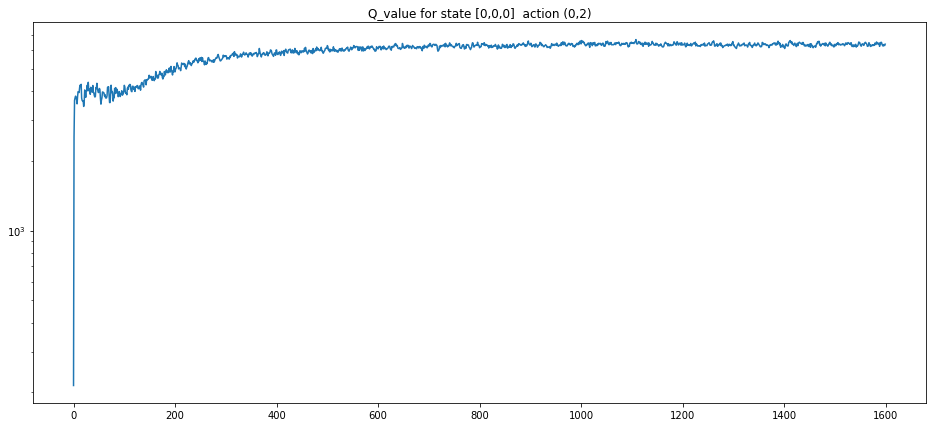

In [9]:
#Plot the Q-Value convergence for state action pairs

plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

In [10]:
#Track rewards per episode
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

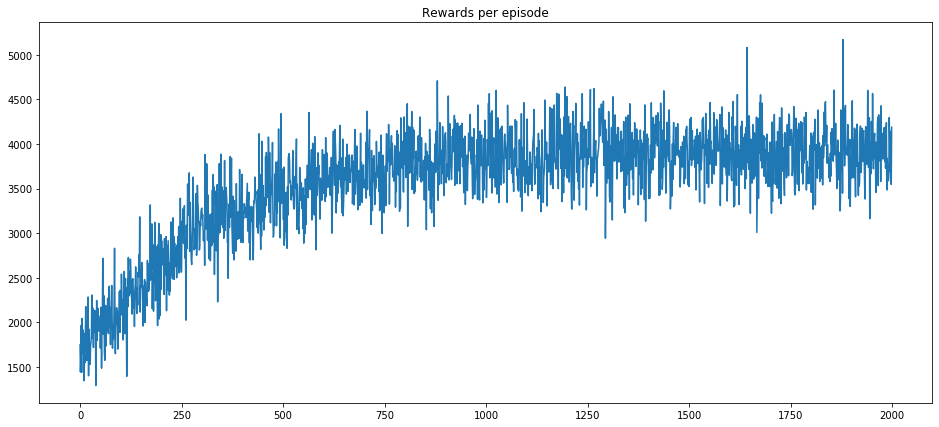

In [11]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [12]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

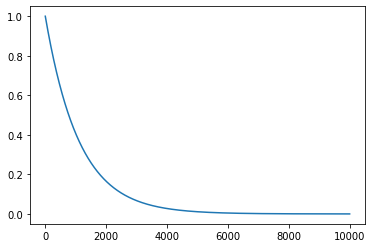

In [13]:
plt.plot(time, epsilon)
plt.show()